In [1]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import sklearn
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import gc
print(os.listdir("../input"))
data_trian_path  = '../input/train/'

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(filenames)



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['histopathologic-cancer-detection']


In [2]:
# loading data
full_train_df = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
full_train_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# BASIC EDA

print("Train Size: {}".format(len(os.listdir('../input/histopathologic-cancer-detection/train/'))))
print("Test Size: {}".format(len(os.listdir('../input/histopathologic-cancer-detection/test/'))))


Train Size: 220025
Test Size: 57458


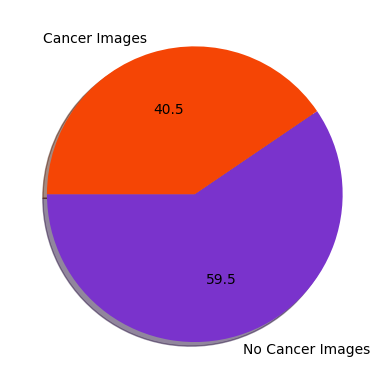

<Figure size 1600x1600 with 0 Axes>

In [4]:
labels_count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer Images', 'Cancer Images'], startangle=180, 
        autopct='%1.1f', colors=['#7a33cc','#f54505'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()



In [5]:
# loading 70000 of data
SAMPLE_SIZE = 70000


train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'


df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)


train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape


(140000, 2)

In [6]:
# dataset class
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
import torchvision.transforms as transforms

transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)


In [8]:
from torch.utils.data import DataLoader, SubsetRandomSampler

batch_size = 128

valid_size = 0.1

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)


In [9]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

sample_sub = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [11]:
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [12]:
model = CNN()
print(model)

if train_on_gpu: model.cuda()


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [13]:
import torch.optim as optim

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [14]:
from sklearn.metrics import roc_auc_score


In [15]:

n_epochs = 1

valid_loss_min = np.Inf

train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        print("done",end=" ")
        
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        

    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
        valid_loss_min = valid_loss

done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done done 

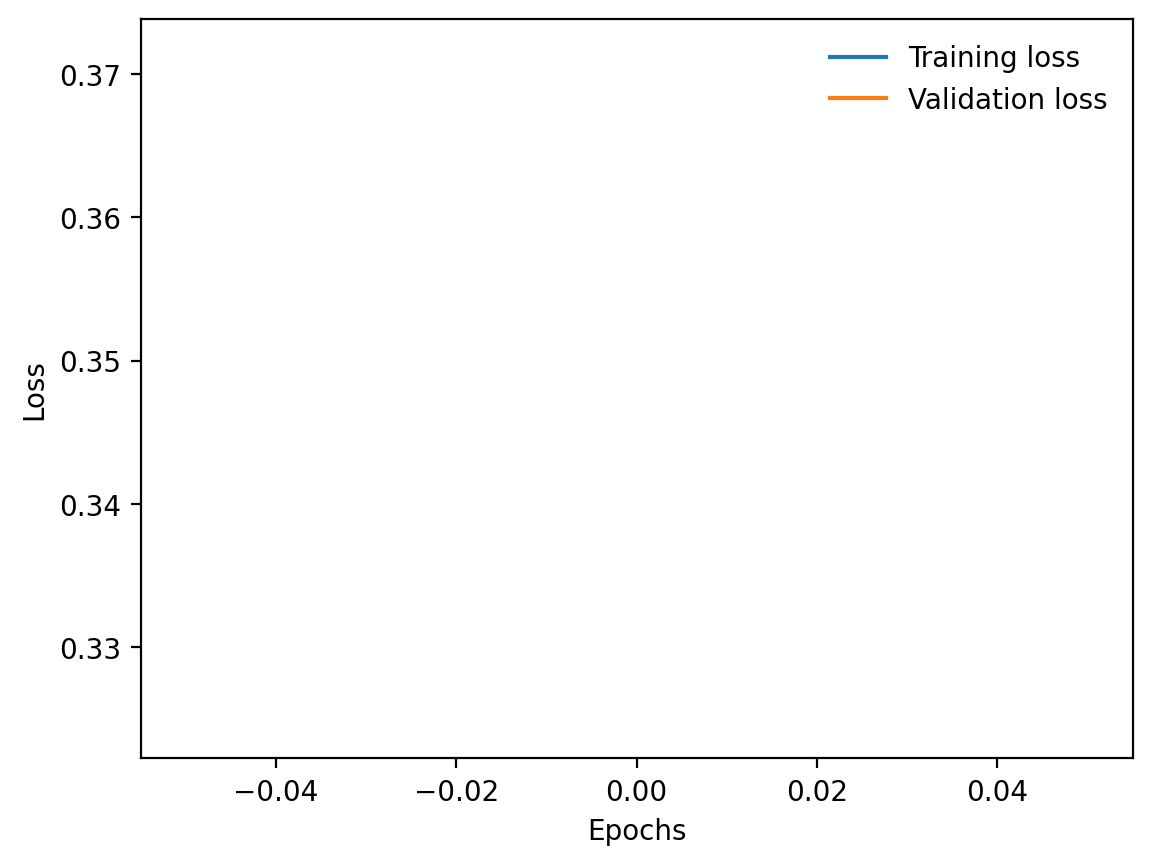

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)


In [17]:
# model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
print(len(train_losses))

1


In [18]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['label'] = preds


In [19]:
for i in range(len(sample_sub)):
    sample_sub['label'] = sample_sub['label'].astype(float)



In [20]:
sample_sub.to_csv('/kaggle/working/submission.csv', index=False)
sample_sub.head(90)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.074436
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.896663
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.058667
3,2c35657e312966e9294eac6841726ff3a748febf,0.190705
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.167665
...,...,...
85,69e4380d700aaf956d154792228f24f4e6c1c1e2,0.022293
86,8878c3c8a3d55bb376b1e3a9ca89d07df11e3b48,0.365655
87,327d61477090c5f95237773e9a47528129c465c1,0.791921
88,fff69b7e90d979503222591557d5191dc74e9c9a,0.946828
